In [1]:
import random
import numpy as np
import pandas as pd
import networkx as nx
import network_distance as nd
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

In [2]:
# Q1: What is the level of opinion polarization in the Obamacare debate?
# A: Read the network, read the opinion values from the X vector, calculate the ge distance of those values with a vector of zeros
G_obama = nx.read_edgelist("../data/obama_edgelist.csv", delimiter = ",", nodetype = int)
vector_df = pd.read_csv("../data/obama_nodevectors.csv")
v1_dict = vector_df.set_index("node").to_dict()["X"]

print(f"Obamacare opinion polarization: {nd.ge(v1_dict, {}, G_obama, normed = False):.4f}")

Obamacare opinion polarization: 9.4405


In [3]:
# Q2: Is the Gun Control debate more or less ideologically polarized than Obamacare?
# A: Repeat the previous approach but this time on the gun control network and compare the scores
G_guncontrol = nx.read_edgelist("../data/guncontrol_edgelist.csv", delimiter = ",", nodetype = int)
vector_df = pd.read_csv("../data/guncontrol_nodevectors.csv")
v2_dict = vector_df.set_index("node").to_dict()["X"]

print(f"Gun control opinion polarization: {nd.ge(v2_dict, {}, G_guncontrol, normed = False):.4f}")

Gun control opinion polarization: 11.1718


In [4]:
# Q3: What is the level of affective polarization in the Obamacare debate?
# A: Make line graph of the network, for each edge calculate the ideological difference, then read each edge's sentiment score and calcualte the network correlation.
G_obama_line = nx.line_graph(G_obama)
edge_df = pd.DataFrame(data = G_obama_line.nodes, columns = ("n1", "n2"))

edge_df["ideo_diff"] = edge_df.apply(lambda x: abs(v1_dict[x["n1"]] - v1_dict[x["n2"]]), axis = 1)

edge_sentiment = pd.read_csv("../data/obama_edgevectors.csv")
edge_df = edge_df.merge(edge_sentiment, on = ["n1", "n2"])

ideo_dict = {(row["n1"], row["n2"]): row["ideo_diff"] for index, row in edge_df.iterrows()}
senti_dict = {(row["n1"], row["n2"]): row["sentiment"] for index, row in edge_df.iterrows()}

print(f"Obamacare affective polarization: {nd.correlation(ideo_dict, senti_dict, G_obama_line):.4f}")

Obamacare affective polarization: 0.9861


In [5]:
# Q4: Which country is more spread out in the Product Space between the United States, Japan, Thailand, and Malawi?
# A: Read the Product Space network, make a vector of "product -> RCA" for each country, calculate their network variance (dispersion)
G_ps = nx.read_edgelist("../data/product_space.csv", delimiter = ",", nodetype = str)
exports = pd.read_csv("../data/country_exports.csv", dtype = {"sitc": str})

usa = exports[exports["exporter"] == "USA"].set_index("sitc")["rca"].to_dict()
jpn = exports[exports["exporter"] == "JPN"].set_index("sitc")["rca"].to_dict()
tha = exports[exports["exporter"] == "THA"].set_index("sitc")["rca"].to_dict()
mwi = exports[exports["exporter"] == "MWI"].set_index("sitc")["rca"].to_dict()

spls = nd._resistance(G_ps) # Since the network doesn't change, we can calculate the effective resistance matrix only once and reuse it

print(f"""
Network variance of USA: {nd.variance(usa, G_ps, shortest_path_lengths = spls, kernel = "resistance")};
Network variance of JPN: {nd.variance(jpn, G_ps, shortest_path_lengths = spls, kernel = "resistance")};
Network variance of THA: {nd.variance(tha, G_ps, shortest_path_lengths = spls, kernel = "resistance")};
Network variance of MWI: {nd.variance(mwi, G_ps, shortest_path_lengths = spls, kernel = "resistance")};
""")


Network variance of USA: 10.14276001368656;
Network variance of JPN: 4.587322939017621;
Network variance of THA: 10.842231906519588;
Network variance of MWI: 21.72494134249552;



In [6]:
# Q5: Can we retrieve the infection parameter of a disease by observing its speed in propagating through a social network?
# A: Make a function simulating the S -> I step of a simple infection model, run it on a network with communities for different beta values,
#    then calculate the ge distance between initial and final state after the infection. Calculate the spearman correlation between the beta
#    values and the ge values.
def si(G, seed, beta, steps = 10):
    i_nodes = seed.copy()  # i_nodes is the set of currently infectious nodes
    for _ in range(steps): # For each step in the simulation...
        # ...we identify the susceptible nodes with at least one infected neighbor...
        s_neighbors_of_i = {n for i_node in i_nodes for n in G.neighbors(i_node)} - i_nodes
        for s_node in s_neighbors_of_i: # ...for each of these susceptible nodes...
            if random.random() < beta:  # ...with probability beta...
                i_nodes.add(s_node)     # ...we add them to the infected set
    return i_nodes

betas = np.random.uniform(low = 0.0, high = 0.05, size = 1000) # Pick 1000 betas uniformly at random between 0 and 0.05
# Make a network with 4 communities of 100 nodes each. Each community has an internal density of 10%,
# and connects with 0.1% of the possible edges to each of the other communities
G_sbm = nx.stochastic_block_model([100] * 4, [[0.1, 0.001, 0.001, 0.001], [0.001, 0.1, 0.001, 0.001], [0.001, 0.001, 0.1, 0.001], [0.001, 0.001, 0.001, 0.1]])

Q = nd._ge_Q(G_sbm) # Since the network doesn't change, we can pseudoinvert the Laplacian only once, and reuse the result
ges = []

for beta in betas:                                             # For each of the infection parameters beta...
    seed = set(random.sample(list(G_sbm.nodes), 10))           # ...we pick the intial infected set of ten nodes at random
    infected = si(G_sbm, seed, beta)                           # We run the SI models for 10 steps
    seed_dict = {i: 1 for i in seed}                           # We make a dictionary with a value of 1 per node in the original seed set
    infected_dict = {i: 1 for i in infected}                   # We make a dictionary with a value of 1 per node in the final infected set
    ges.append(nd.ge(seed_dict, infected_dict, G_sbm, Q = Q))  # We calculate the ge between original seeds and final infected and store it in a list

df = pd.DataFrame()
df["beta"] = betas
df["ge"] = ges

df.corr(method = "spearman")

,beta,ge
beta,1.000000,0.837504
ge,0.837504,1.000000


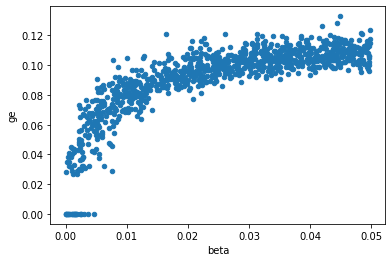

In [7]:
df.plot(x = "beta", y = "ge", kind = "scatter")
plt.show()